# Population Structure Analysis of *Anopheles gambiae*  in Uganda 

A notebook that use PCA to explore population differentiation in Uganda




In [1]:
#Install and load packages
import plotly.express as px
import plotly.graph_objs as go
import malariagen_data
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.io as bkio
bkio.output_notebook()
from bokeh.io import export_png
import bokeh.plotting as bkplt
from bokeh.models import Range1d
import os
import ipyleaflet
import allel



/home/harunnn/.conda/envs/gaard/lib/python3.10/site-packages/anjl/_canonical.py:187: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  n_threads = get_num_threads()


Loading BokehJS ...

## Principle component analysis

In [2]:

sample_sets = ["1288-VO-UG-DONNELLY-VMF00168","1288-VO-UG-DONNELLY-VMF00219"]
sample_query = "aim_species == 'gambiae' & sex_call == 'F'"
#load malariagen data
ag3 = malariagen_data.Ag3(pre = True)
# Initially, we don't use a sample query
meta = ag3.sample_metadata(
    sample_sets=sample_sets, 
)
# Remove decimal and numbers after it in the "partner_sample_id" column not present in our meta data
meta['partner_sample_id'] = meta['partner_sample_id'].str.split('.').str[0]
print(meta.shape)

# Convert "partner_sample_id" column in meta to float64 to match llineup_meta dtype
meta['partner_sample_id'] = pd.to_numeric(meta['partner_sample_id'])
#llineup trial metadata
llineup_meta = pd.read_csv('~/lstm_scratch/network_scratch/llineup/llineup-genomics/data/ento_geno_plasmo_data.csv',
                       index_col = 0,
                      ).query("species=='An. gambiae'")
llineup_meta= llineup_meta.drop_duplicates(subset=['wgs.sample.id'])
llineup_meta= llineup_meta.set_index('wgs.sample.id')
llineup_meta = llineup_meta.reindex(index=meta['partner_sample_id'])#match order in malariagen meta data
llineup_meta=llineup_meta.reset_index()
llineup_meta['sample_id'] =meta['sample_id'] #create sample id to merge with ag3 metadata
sample_query_filter = (meta['aim_species'] == 'gambiae') & (meta['sex_call'] == 'F')

#add column control phase for grouping samples to pre and post interventions
rnd_map = {1: 'pre', 5: 'post'}

llineup_meta['control_phase'] = llineup_meta['RND'].map(rnd_map).fillna('intermediate')

llineup_meta.rename(columns={'LLIN.actual':'llin_actual'}, inplace = True)
ag3.add_extra_metadata(llineup_meta)
# Re-download the metadata with the additional columns
meta = ag3.sample_metadata(
    sample_sets=sample_sets, 
).set_index('sample_id')
meta['partner_sample_id'] = meta['partner_sample_id_x'].str.split('.').str[0]
meta['partner_sample_id'] = pd.to_numeric(meta['partner_sample_id'])

sample_query_filter = ((meta['aim_species'] == 'gambiae') & \
                      (meta['sex_call'] == 'F') & \
                      (np.array(list(meta['Location'])) != 'nan')).values
meta = meta.iloc[sample_query_filter, :]
meta


(1222, 57)                           


,partner_sample_id_x,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,...,LLIN.intend,llin_actual,Net.intend,Net.actual,Wave,Location,subregions,species,control_phase,partner_sample_id
sample_id,,,,,,,,,,,,,,,,,,,,,
VBS50275-6645STDY11194051,108402032009,Martin Donnelly,Uganda,8402,2017,5,0.878,33.333,F,1288-VO-UG-DONNELLY-VMF00168,...,Non-PBO LLIN,Non-PBO LLIN,PermaNet-2,PermaNet-2,3.0,East,East Central,An. gambiae,pre,108402032009
VBS50276-6645STDY11194052,108402032004,Martin Donnelly,Uganda,8402,2017,5,0.878,33.333,F,1288-VO-UG-DONNELLY-VMF00168,...,Non-PBO LLIN,Non-PBO LLIN,PermaNet-2,PermaNet-2,3.0,East,East Central,An. gambiae,pre,108402032004
VBS50283-6645STDY11194053,108405057028,Martin Donnelly,Uganda,8405,2017,5,0.957,33.341,F,1288-VO-UG-DONNELLY-VMF00168,...,Non-PBO LLIN,Non-PBO LLIN,PermaNet-2,PermaNet-2,3.0,East,East Central,An. gambiae,pre,108405057028
VBS50286-6645STDY11194055,108405057024,Martin Donnelly,Uganda,8405,2017,5,0.957,33.341,F,1288-VO-UG-DONNELLY-VMF00168,...,Non-PBO LLIN,Non-PBO LLIN,PermaNet-2,PermaNet-2,3.0,East,East Central,An. gambiae,pre,108405057024
VBS50287-6645STDY11194056,108405057036,Martin Donnelly,Uganda,8405,2017,5,0.957,33.341,F,1288-VO-UG-DONNELLY-VMF00168,...,Non-PBO LLIN,Non-PBO LLIN,PermaNet-2,PermaNet-2,3.0,East,East Central,An. gambiae,pre,108405057036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBS67021-6645STDY13057665,400306001035.000,Martin Donnelly,Uganda,306,2019,9,0.713,29.996,F,1288-VO-UG-DONNELLY-VMF00219,...,Non-PBO LLIN,Non-PBO LLIN,Olyset,Olyset,5.0,West,Mid-Western,An. gambiae,intermediate,400306001035
VBS67022-6645STDY13057666,400306001036.000,Martin Donnelly,Uganda,306,2019,9,0.713,29.996,F,1288-VO-UG-DONNELLY-VMF00219,...,Non-PBO LLIN,Non-PBO LLIN,Olyset,Olyset,5.0,West,Mid-Western,An. gambiae,intermediate,400306001036
VBS67024-6645STDY13057668,400306001038.000,Martin Donnelly,Uganda,306,2019,9,0.713,29.996,F,1288-VO-UG-DONNELLY-VMF00219,...,Non-PBO LLIN,Non-PBO LLIN,Olyset,Olyset,5.0,West,Mid-Western,An. gambiae,intermediate,400306001038



### PCA to investigate structure


In [3]:
sample_sets=["1288-VO-UG-DONNELLY-VMF00168" ,"1288-VO-UG-DONNELLY-VMF00219"]
sample_query_pre="taxon == 'gambiae' & control_phase =='pre'"
sample_query_post="taxon == 'gambiae' & control_phase =='post'"
n_snps = 100000

In [4]:
region = 'X'
pca_x_df, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_pre)

Compute SNP allele counts:   0%|          | 0/2028 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/3510 [00:00<?, ?it/s]

In [ ]:
region = 'X'
pca_x_df_post, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_post)

In [5]:
region = '2R'
pca_2R_df, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_pre)

Compute SNP allele counts:   0%|          | 0/5226 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/9045 [00:00<?, ?it/s]

In [6]:
region = '2L'
pca_2L_df, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_pre)

Compute SNP allele counts:   0%|          | 0/4212 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/7290 [00:00<?, ?it/s]

In [ ]:
region = '2R'
pca_2R_df_post, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_post)

In [ ]:
region = '2RL:'
pca_2L_df_post, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_post)

In [7]:
region = '3L'
pca_3L_df, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_pre)

Compute SNP allele counts:   0%|          | 0/3536 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/6120 [00:00<?, ?it/s]

In [8]:
region = '3R'
pca_3R_df, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_pre)

Compute SNP allele counts:   0%|          | 0/4550 [00:00<?, ?it/s]

Compute biallelic diplotypes:   0%|          | 0/7785 [00:00<?, ?it/s]

In [ ]:
region = '3L'
pca_3L_df_post, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_post)

In [ ]:
region = '3R'
pca_3R_df_post, evr = ag3.pca(region=region, n_snps=n_snps, sample_sets=sample_sets,sample_query=sample_query_post)

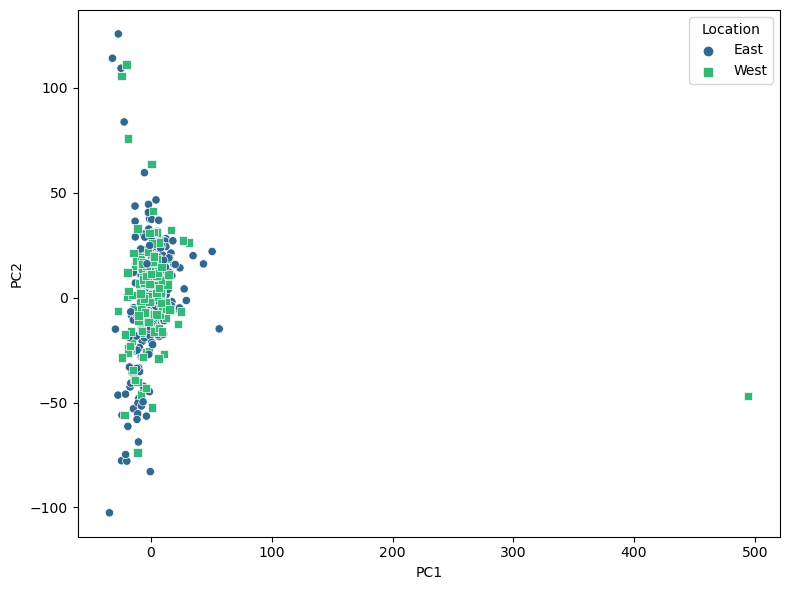

In [17]:

# Define the palette for coloring the points
palette = "viridis"

# Define the markers for differentiating points
markers = {"East": "o",  # Circle
           "West": "s"}  # Square

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Location", style="Location",
                markers=markers, data=pca_3L_df, palette=palette)

# Customize plot aesthetics
#plt.title('Population structure in Uganda pre intervention')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)  # Turn off grid lines
plt.tight_layout()

# Save 
#plt.savefig('pre_intervention_2L_pca_plot.png', dpi=300)
plt.savefig('pre_intervention_3L_pca.svg', format='svg')
# Show plot
plt.show()


In [60]:
# Define threshold for outliers
threshold = 0

# Filter out extreme outliers
filtered_data = pca_2L_df[(pca_x_df['PC1'] < threshold)]#| (pca_x_df['PC2'] > threshold)]
np.sum(filtered_data.Location=='West')


142

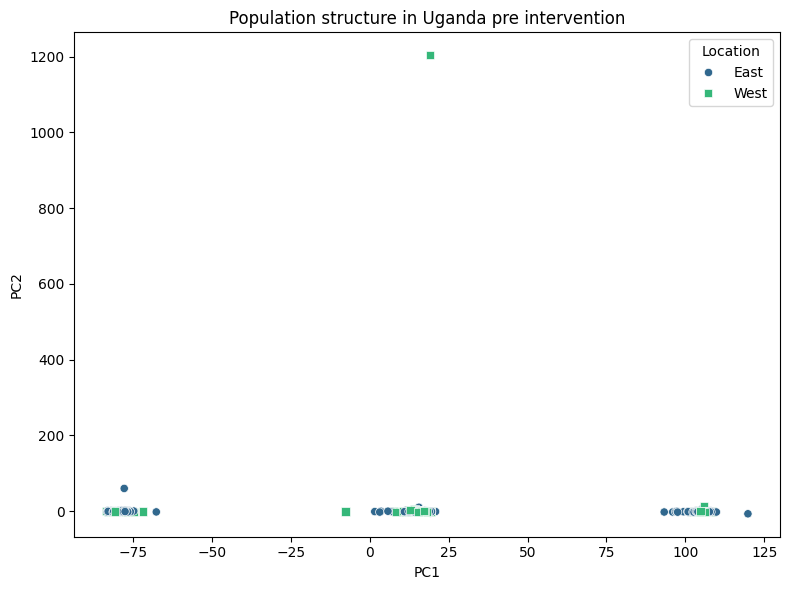

In [7]:

# Define threshold for outliers
threshold = 700

# Filter out extreme outliers
filtered_data = pca_2L_df[(pca_2L_df['PC1'] < threshold) & (pca_2L_df['PC2'] < threshold)]

# Define the palette for coloring the points
palette = "viridis"

# Define the markers for differentiating points
markers = {"East": "o",  # Circle
           "West": "s"}  # Square

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Location", style="Location",
                markers=markers, data=pca_2L_df, palette=palette)

# Customize plot aesthetics
plt.title('Population structure in Uganda pre intervention')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)  # Turn off grid lines
plt.tight_layout()



# Save 
plt.savefig('pre_intervention_2L_minus_outliers.png', dpi=300)

# Show plot
plt.show()


In [10]:
pca_2L_df.to_csv('2l_pca_inversion.csv', index = False)

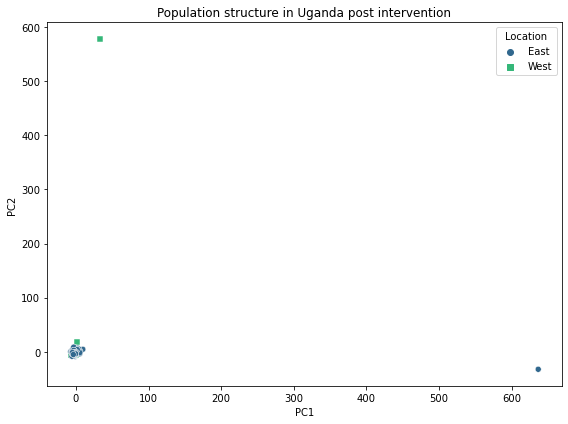

In [72]:
# Define the palette for coloring the points
palette = "viridis"

# Define the markers for differentiating points
markers = {"East": "o",  # Circle
           "West": "s"}  # Square

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Location", style="Location",
                markers=markers, data=pca_x_df_post, palette=palette)

# Customize plot aesthetics
plt.title('Population structure in Uganda post intervention')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)  # Turn off grid lines
plt.tight_layout()

# Save 
plt.savefig('post_intervention_x_pca_plot.png', dpi=300)

# Show plot
plt.show()


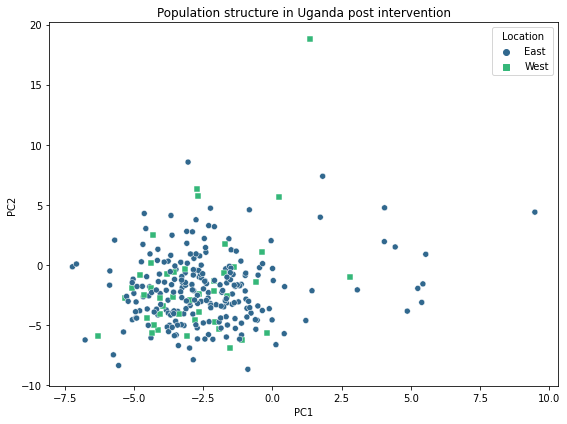

In [73]:
# Define threshold for outliers
threshold = 500

# Filter out extreme outliers
filtered_data = pca_x_df_post[(pca_x_df_post['PC1'] < threshold) & (pca_x_df_post['PC2'] < threshold)]

# Define the palette for coloring the points
palette = "viridis"

# Define the markers for differentiating points
markers = {"East": "o",  # Circle
           "West": "s"}  # Square

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Location", style="Location",
                markers=markers, data=filtered_data, palette=palette)

# Customize plot aesthetics
plt.title('Population structure in Uganda post intervention')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)  # Turn off grid lines
plt.tight_layout()



# Save 
plt.savefig('post_intervention_x_minus_outliers.png', dpi=300)

# Show plot
plt.show()

In [24]:
#alternative plotting function
fig = px.scatter(pca_3L_df_15, x="PC1", y="PC2",color="RND",symbol='LLIN_actual')

for i, trace in enumerate(fig.data):
    name = trace.name.split(',')
    if name[1] == ' Non-PBO LLIN':
        trace['name'] = ''
        trace['showlegend']=False
    else:
        trace['name'] = name[0]
fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='circle', color='black'),
                         name='Non-PBO LLIN',
                         ))
fig.add_trace(go.Scatter(y=[None], mode='markers',
                         marker=dict(symbol='diamond', color='black'),
                         name='PBO LLIN',
                         ))